# EMNLP 2022
# Semantic Legal Searcher : Dynamic Semantic Law case Search Procedure (Seoul National University_Yoonseop Lee)

# 0. Import

In [ ]:
! pip install transformers
! pip install -U sentence-transformers
! pip install sentencepiece
! pip install faiss-gpu
! pip install pytrends
! pip install funcy pickle5

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import pytrends
from pytrends.request import TrendReq
import datetime
from dateutil.relativedelta import relativedelta
import scipy.stats as stats

from sentence_transformers import SentenceTransformer, util

# 1. Clean Korean Legal Corpus (CKLC) 

In [ ]:
# Load Legal Dataset(Get Only Judicial precedent data)
df = pd.read_csv('./data/cases_with_hits(20220521).csv')
df = df.dropna(how='any')
# Make index for clustering
print(">> Judicial precedent data size : ",len(df))

df.head()

>> Judicial precedent data size :  62919


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm
0,미성년자의제강간,2021노824,20220415.0,400102.0,피고인이 카카오톡 오픈채팅방을 통해 미성년자 여 11세 을 알게 된 후 당시 13세...,피고인이 카카오톡 오픈채팅방을 통해 미성년자 여 11세 을 알게 된 후 당시 13세...,【피 고 인】 피고인【항 소 인】 쌍방【검 사】 이지은 외 1인【변 호 인】 ...,83499,7059,0.702929
2,손해배상(기),2021나24173,20220323.0,400101.0,이 을 상대로 소송을 제기하자 이 과 소송위임계약을 체결하여 이 을 대리하여 소송을...,이 을 상대로 소송을 제기하자 이 과 소송위임계약을 체결하여 이 을 대리하여 소송을...,"【원고, 항소인 겸 피항소인】 원고 (소송대리인 법무법인 우정 담당변호사 김병구 외...",83497,9296,0.928889
4,손해배상(의)[환자가 치료 도중 뇌출혈로 사망하자 의료과실에 의한 손해배상을 구하는...,2018다263434,20220317.0,400101.0,의사가 의료행위를 할 때 취하여야 할 주의의무의 정도 및 기준 특히 환자가 병원에서...,의사가 진찰 치료 등의 의료행위를 할 때에는 사람의 생명 신체 건강을 관리하는 업무...,"【원고, 상고인】 원고 1 외 2인 (소송대리인 변호사 신현호 외 4인)【피고, 피...",83495,8591,0.857677
5,상표법위반·업무상배임[타인의 상표가 부착된 제품을 무상으로 제공한 경우 상표법위반죄...,2021도2180,20220317.0,400102.0,1 상표법상 상표의 사용 및 상품의 의미 2 피고인 은 상표권자의 허락 없이 상표를...,1 상표법상 상표의 사용이란 상품 또는 상품의 포장에 상표를 표시하는 행위 상품 또...,【피 고 인】 피고인 1 외 1인【상 고 인】 검사【원심판결】 서울서부지법 2021...,83494,8359,0.834242
6,소유권이전등기·소유권이전등기[피고로부터 부동산을 증여받은 원고들이 피고를 상대로 증...,"2017다207475, 207482",20220311.0,400101.0,1 수증자의 범죄행위를 원인으로 한 증여계약의 해제를 규정하고 있는 민법 제556조...,1 민법 제556조 제1항 제1호는 수증자가 증여자에 대하여 증여자 또는 그 배우자...,"【원고(반소피고), 상고인】 원고(반소피고) (소송대리인 법무법인(유한) 세종 담당...",83493,4536,0.448081


In [ ]:
def text_len_plot(dataframe, col):
    """
    dataframe : DataFrame
    col : str(Column name)
    """
    dataframe['text_len'] = dataframe[col].apply(lambda words : len(words.split()))
    #dataframe['sent_len'] = dataframe[col].apply(lambda words : len(words.split(".")))
    mean_seq_len = np.round(dataframe['text_len'].mean() + dataframe['text_len'].std()).astype(int)
    #mean_sent_len = np.round(dataframe['sent_len'].mean() + dataframe['sent_len'].std()).astype(int)
    print(">> {} Average Text length : {}".format(col, mean_seq_len))
    print(">> {} Max Text length : {}".format(col, dataframe['text_len'].max()))
    print(">> {} Text words : {}".format(col, dataframe['text_len'].sum()))
    #print(">> Average Sentence length : ", mean_sent_len)
    #print(">> Max Sentence length : ", dataframe['sent_len'].max())

    plt.figure(figsize=(12,6))
    sns.histplot(dataframe['text_len'], kde=True, color='royalblue', label='Text_length')
    plt.axvline(x=mean_seq_len, color='r', linestyle='--', label='max_length')
    plt.title('Text length'); plt.legend()
    plt.show()

>> judgment_issue Average Text length : 62
>> judgment_issue Max Text length : 573
>> judgment_issue Text words : 1944875


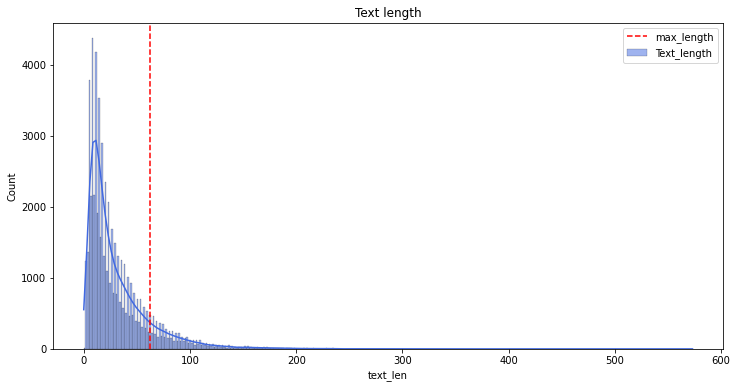

>> judgment_summary Average Text length : 211
>> judgment_summary Max Text length : 2889
>> judgment_summary Text words : 6550292


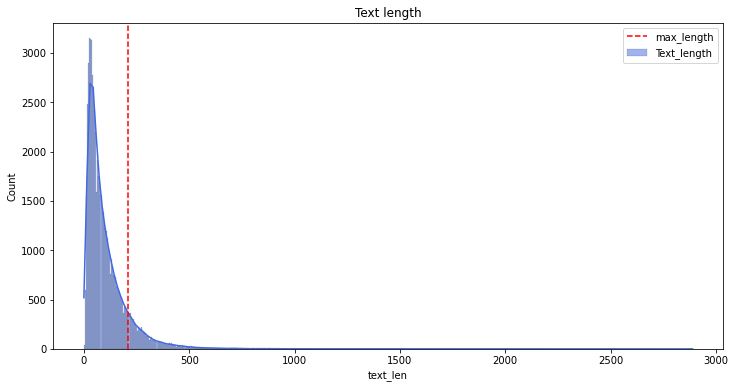

>> judgment_contents Average Text length : 1457
>> judgment_contents Max Text length : 37418
>> judgment_contents Text words : 41963504


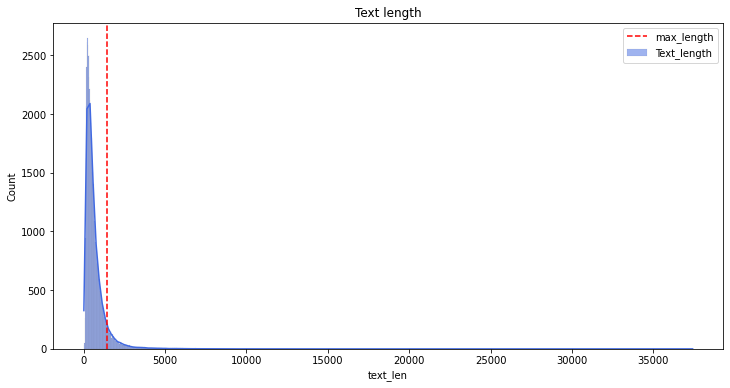

>> case_name Average Text length : 2
>> case_name Max Text length : 57
>> case_name Text words : 71620


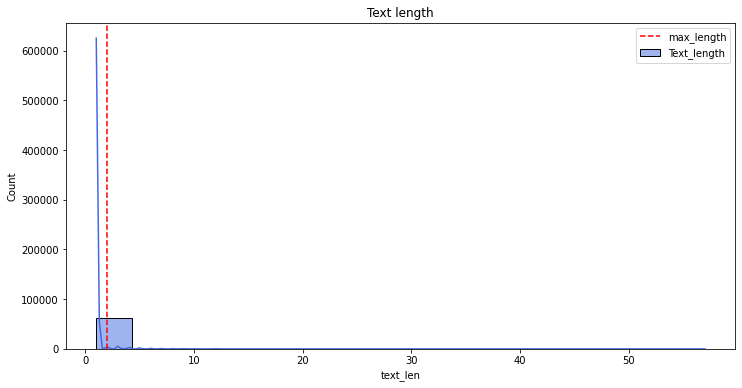



 >> CKLC consisit of 52380564 words of legal text 


In [ ]:
# Text Length
# 1. Judgment_issue
text_len_plot(df, 'judgment_issue')
# 2. judgment_summary
text_len_plot(df, 'judgment_summary')
# 3. judgment_full-text
text_len_plot(df, 'judgment_contents')
# 4. case_name
text_len_plot(df, 'case_name')

# 5. Words
print("\n\n >> CKLC consisit of {} words of legal text ".format(1944875+6550292+41963504+71620+1850273))

# 2. Parallel Clustering Topic Modeling

In [ ]:
from models.parallel_topic_model import *

In [ ]:
my_model = '../S_bert/output/training_distillation_sts_roberta-base'
target_column = 'judgment_summary'

cluster = ParallelCluster(
    dataframe = df,
    tgt_col = target_column,
    model_name = my_model,
    use_sentence_bert = True
    )

Batches:   0%|          | 0/1967 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62919, 768)


In [ ]:
# 1. Parallel Clustering
clusters, unclusters= cluster.parallel_cluster(
    clusters = None,
    threshold = 0.83,
    page_size = 2500,
    iterations = 15
    )

=== Iteration 1 / 15 ===


>> Number of Total Clusters :  338
>> Percentage clusted Doc Embeddings : 11.31%


=== Iteration 2 / 15 ===


>> Number of Total Clusters :  587
>> Percentage clusted Doc Embeddings : 15.99%


=== Iteration 3 / 15 ===


>> Number of Total Clusters :  767
>> Percentage clusted Doc Embeddings : 18.75%


=== Iteration 4 / 15 ===


>> Number of Total Clusters :  897
>> Percentage clusted Doc Embeddings : 20.33%


=== Iteration 5 / 15 ===


>> Number of Total Clusters :  990
>> Percentage clusted Doc Embeddings : 21.39%


=== Iteration 6 / 15 ===


>> Number of Total Clusters :  1094
>> Percentage clusted Doc Embeddings : 22.49%


=== Iteration 7 / 15 ===


>> Number of Total Clusters :  1166
>> Percentage clusted Doc Embeddings : 23.23%


=== Iteration 8 / 15 ===


>> Number of Total Clusters :  1232
>> Percentage clusted Doc Embeddings : 23.84%


=== Iteration 9 / 15 ===


>> Number of Total Clusters :  1304
>> Percentage clusted Doc Embeddings : 24.58%


=== It

In [ ]:
# 2. Stack : Stack the clustered results in order of cluster size
col_list = ['case_name', 'case_number', 'date', 'case_code', 'judgment_issue', 'judgment_summary',
            'judgment_contents', 'case_id', 'case_hits', 'case_hits_norm']

new_df = cluster.cluster_stack(
    col_list = col_list,
    clusters = clusters,
    unclusters = unclusters
    )

# 3. Topic Modeling : Extract Latent Topics (or Keywords)
top_n_words = cluster.extract_top_n_words_per_topic(
    dataframe = new_df,
    n = 20,
    en = False
    )

new_df['Topic_Modeling'] = [top_n_words[i] for i in new_df['Topic'].values]

new_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['못하다', '아니다', '안된다', '않고', '않기', '없고', '하고', '하기'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm,Topic,Topic_Modeling
16,손해배상(기),2021다275741,20220217.0,400101.0,1 별소로 계속 중인 채권을 자동채권으로 하는 소송상 상계의 주장이 허용되는지 여부...,1 상계의 항변을 제출할 당시 이미 자동채권과 동일한 채권에 기한 소송을 별도로 제...,"【원고, 피상고인】 원고 (소송대리인 법무법인 성연 담당변호사 김은지 외 2인)【피...",83483,8603,0.858889,0,"[(제1심, 0.02336371090067417), (원고의, 0.021291117..."
567,손해배상(기)청구의소,2020다292411,20210507.0,400101.0,1 항소심에 이르러 새로운 청구가 추가된 경우 항소심이 기존의 청구와 추가된 청구를...,1 항소심에 이르러 새로운 청구가 추가된 경우 항소심은 추가된 청구에 대해서는 실질...,"【원고, 상고인】 원고 (소송대리인 법무법인 게이트 담당변호사 윤영선 외 3인)【피...",82932,7281,0.725354,0,"[(제1심, 0.02336371090067417), (원고의, 0.021291117..."
578,추심금,2018다259213,20210507.0,400101.0,1 전소가 후소의 변론종결 시까지 취하 각하 등에 의하여 소송계속이 소멸되는 경우 ...,1 민사소송법 제259조는 법원에 계속되어 있는 사건에 대하여 당사자는 다시 소를 ...,"【원고, 피상고인】 원고 1 외 1인 (소송대리인 법무법인 현정 외 1인)【피고, ...",82921,9557,0.955253,0,"[(제1심, 0.02336371090067417), (원고의, 0.021291117..."
1414,손해배상(기),2018다221867,20200326.0,400101.0,1 1개의 청구 일부를 기각하는 제1심판결에 대하여 일방 당사자만이 항소한 경우 항...,1 1개의 청구 일부를 기각하는 제1심판결에 대하여 일방 당사자만이 항소한 경우 제...,"【원고, 피상고인】 원고 (소송대리인 법무법인 청린 담당변호사 정원일)【피고, 상고...",82085,5892,0.585051,0,"[(제1심, 0.02336371090067417), (원고의, 0.021291117..."
1590,도로교통법위반(음주운전),2019도5426,20191031.0,400102.0,1 항소심에서 피고인이 불출석한 상태에서 그 진술 없이 판결하기 위한 요건 2 피고...,1 항소심에서도 피고인의 출석 없이는 개정하지 못하는 것이 원칙이다 형사소송법 제3...,【피 고 인】 피고인【상 고 인】 피고인【변 호 인】 변호사 이익현 외 2인【원심판...,81909,8896,0.888485,0,"[(제1심, 0.02336371090067417), (원고의, 0.021291117..."


# 3. Semantic Legal Searcher

In [ ]:
# 1. Load Clustered DataFrame
new_df = pd.read_csv('./data/clusted_df.csv')

In [ ]:
from models.semantic_law_search import *

In [ ]:
# 2. KoLawBERT Models
# Pre-trained LM 
my_model = '../S_bert/output/training_distillation_sts_roberta-base'

law_bert = KoLawBERT(
    dataframe= new_df,
    tgt_col = 'judgment_summary',
    model_name = my_model,
    use_sentence_bert = True,
    cluster = True
                     )

Batches:   0%|          | 0/1967 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62919, 768)


In [ ]:
# 3. Build the Index
# 3-1.(Strategy 1) : Calculate Vector Similarity with All text embeddings
index_1 = law_bert.all_relevant_embedding()

# 3-2.(Strategy 2) : Calculate Vector Similarity with Centroid of embeddings
index_2 = law_bert.centroid_relevant_embedding(nlist = 200, nprobe = 6)

In [ ]:
# 4. Search
# "The tenant does not pay rent to me, the landlord for 3 months."
my_query = "세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다."

# 4-1. Search the Law cases(Strategy 1)
original_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_1
    )


 === Calculate run time : 102.4103 ms === 

>> Write your case : 세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다.

 >> Top 1 - Case name (Number) : 상속세등부과처분취소 (92누10197)  
 | Cluster : 1 
 | Cluster's Topics (Keywords) : [('소유권이전등기를', 0.012397482982072997), ('매도인이', 0.010670625950776547), ('매수인이', 0.009588375067566041), ('부동산을', 0.008512627687063684), ('제3자에게', 0.007602555570412245), ('민법', 0.00731358808583595), ('양수인이', 0.007173534321099034), ('소유권을', 0.006959985911133866), ('매도인의', 0.0066327192736526305), ('부동산의', 0.0065590039511267), ('매수인', 0.006361639696070237), ('양도인의', 0.006217732794087703), ('매수인의', 0.006158225999130342), ('채무를', 0.006136810123188872), ('경우', 0.006095651826107116), ('양도', 0.00594887873501919), ('사정이', 0.00562086912164356), ('부동산에', 0.005614533770911688), ('양도인이', 0.005589818313526113), ('특별한', 0.0055663420948754185)] 
 | Date : 19921009.0 | Judgment Issue : 피상속인의 대지 매각대금이 제3자에게 입금교부된 사실이 밝혀졌을지라도 제3자에 대한 채무의 존재사실이 확인되지 않은 경우 상속세 과세가액에의 산입 가부 적극 
 | Judgment Summary : 피상속인이 그 소유

In [ ]:
# 4-2. Search the Law cases(Strategy 2)
fast_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_2
    )


 === Calculate run time : 23.9139 ms === 

>> Write your case : 세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다.

 >> Top 1 - Case name (Number) : 상속세등부과처분취소 (92누10197)  
 | Cluster : 1 
 | Cluster's Topics (Keywords) : [('소유권이전등기를', 0.012397482982072997), ('매도인이', 0.010670625950776547), ('매수인이', 0.009588375067566041), ('부동산을', 0.008512627687063684), ('제3자에게', 0.007602555570412245), ('민법', 0.00731358808583595), ('양수인이', 0.007173534321099034), ('소유권을', 0.006959985911133866), ('매도인의', 0.0066327192736526305), ('부동산의', 0.0065590039511267), ('매수인', 0.006361639696070237), ('양도인의', 0.006217732794087703), ('매수인의', 0.006158225999130342), ('채무를', 0.006136810123188872), ('경우', 0.006095651826107116), ('양도', 0.00594887873501919), ('사정이', 0.00562086912164356), ('부동산에', 0.005614533770911688), ('양도인이', 0.005589818313526113), ('특별한', 0.0055663420948754185)] 
 | Date : 19921009.0 | Judgment Issue : 피상속인의 대지 매각대금이 제3자에게 입금교부된 사실이 밝혀졌을지라도 제3자에 대한 채무의 존재사실이 확인되지 않은 경우 상속세 과세가액에의 산입 가부 적극 
 | Judgment Summary : 피상속인이 그 소유의

# 4. Dynamic Post-Filtering

## 4-1. Popularity-Based Filtering

In [ ]:
p_outputs = sorted(original_outputs, key=lambda x: x['case_hits'], reverse=True)

print("=== Popularity-based Filtering (Hits) ===")
for i, out in enumerate(p_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

=== Popularity-based Filtering (Hits) ===

 === Law Cases ===

 >> Top 1 - Case name (Number) : 소유권이전등기 (81다257)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('사례', 0.004896036569412943), ('등을', 0.004337618312239961), ('이를', 0.004247669699378535), ('등의', 0.004174338623806773), ('없다', 0.004160367075012021), ('등에', 0.004080273184801406), ('것은', 0.003996007871734252), ('하는', 0.003946599029044887), ('것으로', 0.0038847057650419443), ('제1항', 0.003872393934625668), ('경우', 0.0038681463456208807), ('있다고', 0.0037856481627737736), ('한다', 0.0037779479479895894), ('대한', 0.0036361618924106837), ('하여', 0.003622958862335538), ('법률', 0.0036025954147022653), ('아니라', 0.003552285832598885), ('소정의', 0.0035013862944309076), ('없는', 0.0034989685073296903), ('위한', 0.0034649389738608083)] 
 | Date : 19810728.0 | Judgment Issue : 가 양도담보권자가 담보물에 제3자를 위한 가등기를 한 것이 담보권의 실행인지의 여부 소극 나 채권자가 부동산을 담보로 취득하기 위하여 지출한 비용의 부담자 
 | Judgment Summary : 가양도담보권자가 담보물에 제3자를 위한 가등기 자기의 채무담보를 위하여 채권자에게 가등기 를 마친 것만으로는 담보권의 실행으

## 4-2. User-Based Filtering

In [ ]:
# 0. User cases hits data
user_rating = pd.read_csv('./data/user_hits(20220521).csv')
view_df = new_df[['case_id', 'case_name', 'judgment_issue', 'judgment_summary', 'case_hits', 'case_hits_norm']]
user_df = pd.merge(user_rating, view_df, on='case_id')
print(">> Merge dataframe size : ", len(user_df))
user_df.head()

>> Merge dataframe size :  376443


,user_id,case_id,user_hits,case_name,judgment_issue,judgment_summary,case_hits,case_hits_norm
0,lawyer_0,81089,84,법인세부과처분취소,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,4202,0.414343
1,lawyer_14,81089,3,법인세부과처분취소,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,4202,0.414343
2,lawyer_20,81089,4,법인세부과처분취소,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,4202,0.414343
3,lawyer_23,81089,13,법인세부과처분취소,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,4202,0.414343
4,lawyer_35,81089,97,법인세부과처분취소,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,1 대한민국 정부와 헝가리 인민공화국 정부 간의 소득에 대한 조세의 이중과세회피와 ...,4202,0.414343


In [ ]:
# 1. Make pivot table(user_id x case_id)
user_case_matrix_df = user_df.pivot_table(index = 'user_id', columns = 'case_id', values='user_hits', aggfunc='mean').fillna(0)
print("\n >> Original Matrix shape : ", user_case_matrix_df.shape)
user_case_pivot_matrix = user_case_matrix_df.to_numpy()

# 2. Converting a NumPy sparse matrix to a SciPy compressed sparse row matrix
users_ids = list(user_case_matrix_df.index)
print("\n >> Total User Ids : ", len(users_ids))
users_case_pivot_sparse_matrix = csr_matrix(user_case_pivot_matrix)

# 3. Performs matrix factorization of the original user item matrix
num_of_factors_mf = 10
U, sigma, Vt = svds(users_case_pivot_sparse_matrix, k = num_of_factors_mf)
sigma = np.diag(sigma)

print("\n >> U (Left singular matrix, Relationship between User and latent factors) :", U.shape)
print("\n >> V_transpose (Right singular matrix, Similarity between Items and latent factors) :", Vt.shape)
print("\n >> S (Diagonal matirx, Strength of each latent factors):", sigma.shape)

# 4. Get Interaction matrix = U * S * Vt
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# 5. Min-Max Scaling [0, 1]
all_user_predicted_ratings_norm = (all_user_predicted_ratings-all_user_predicted_ratings.min())/(all_user_predicted_ratings.max()-all_user_predicted_ratings.min())

print("\n >> Interaction Matrix (User x Law Cases) : {}\n".format(all_user_predicted_ratings_norm.shape))

# 6. Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = user_case_matrix_df.columns, index = users_ids).transpose()
print("\n >> Interaction Matrix (Law Cases x User) : {}".format(cf_preds_df.shape))
cf_preds_df.head()


 >> Original Matrix shape :  (50, 62626)

 >> Total User Ids :  50

 >> U (Left singular matrix, Relationship between User and latent factors) : (50, 10)

 >> V_transpose (Right singular matrix, Similarity between Items and latent factors) : (10, 62626)

 >> S (Diagonal matirx, Strength of each latent factors): (10, 10)

 >> Interaction Matrix (User x Law Cases) : (50, 62626)


 >> Interaction Matrix (Law Cases x User) : (62626, 50)


,lawyer_0,lawyer_1,lawyer_10,lawyer_11,lawyer_12,lawyer_13,lawyer_14,lawyer_15,lawyer_16,lawyer_17,...,lawyer_45,lawyer_46,lawyer_47,lawyer_48,lawyer_49,lawyer_5,lawyer_6,lawyer_7,lawyer_8,lawyer_9
case_id,,,,,,,,,,,,,,,,,,,,,
0,0.253269,0.381452,0.331860,0.326882,0.338115,0.300566,0.343966,0.323119,0.302978,0.357120,...,0.363902,0.321899,0.303035,0.326605,0.325400,0.353797,0.345378,0.401554,0.294538,0.333976
1,0.341498,0.366236,0.425247,0.295221,0.644394,0.288646,0.296313,0.475038,0.439636,0.419980,...,0.359787,0.454177,0.271834,0.452454,0.297936,0.217694,0.308295,0.280406,0.288144,0.334868
2,0.347154,0.232411,0.428535,0.269340,0.524044,0.320748,0.357626,0.447115,0.383799,0.316943,...,0.470232,0.390568,0.278467,0.402278,0.435409,0.250447,0.367367,0.270712,0.338558,0.304643
3,0.350939,0.356591,0.448482,0.339096,0.279982,0.352252,0.361647,0.366495,0.344490,0.363209,...,0.356694,0.364738,0.359945,0.351136,0.355285,0.343393,0.289179,0.358935,0.298077,0.332597
4,0.284299,0.510146,0.416837,0.344888,0.314727,0.331608,0.373116,0.341226,0.320101,0.417805,...,0.301840,0.352802,0.349309,0.350424,0.292949,0.344075,0.366711,0.401965,0.301015,0.242301


In [ ]:
## Make function : Combined Orginal semantic search and Utility matrix with weight average of the normalized. ##
def user_based_sementic_search(cf_preds_df, user_id, sementic_weight=0.3, user_weight=0.7):
    user_id = 'lawyer_' + str(user_id)
    # 1. Sorting the User's predictions & score
    sorted_user_preds = cf_preds_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id : 'score'})
    # 2. prepare User table & score
    mean_score = sorted_user_preds['score'].mean()
    user_table = sorted_user_preds.merge(view_df, how='left', left_on='case_id', right_on='case_id')[['case_id', 'case_name', 'judgment_issue', 'judgment_summary','score']]
    # 3. Sementic search table(S-BERT), top 100
    print("******* Original Semantic Law Cases Search *******")
    sementic_table, _ = law_bert.search(user_query = my_query, top_k = 50, index = index_1)

    # 4. Get scaled score = (weight * smentic_rating) + (weight * SVD score)
    for i in sementic_table:
        target_id = i['case_id']
        if target_id in user_table['case_id']:
            # If empty list pass
            if not (user_table[user_table.case_id == target_id].score.values):
                pass
            else:
                scaled_rating = (sementic_weight * i['case_hits_norm']) + (user_weight * float(user_table[user_table.case_id == target_id].score.values))
        else:
            scaled_rating = (sementic_weight * i['case_hits_norm']) + (user_weight * mean_score)
        i['scaled_rating'] = scaled_rating
    
    return sementic_table

In [ ]:
## If User Id is "laywer_10" ##
user_outputs = user_based_sementic_search(cf_preds_df, 10)
user_outputs = sorted(user_outputs, key=lambda x: x['scaled_rating'], reverse=True)
user_outputs = user_outputs[:10]

print("\n\n\n\n ******* User-based Filtering ******* \n\n")
for i, out in enumerate(user_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

******* Original Semantic Law Cases Search *******

 === Calculate run time : 91.4147 ms === 

>> Write your case : 세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다.

 >> Top 1 - Case name (Number) : 상속세등부과처분취소 (92누10197)  
 | Cluster : 1 
 | Cluster's Topics (Keywords) : [('소유권이전등기를', 0.012397482982072997), ('매도인이', 0.010670625950776547), ('매수인이', 0.009588375067566041), ('부동산을', 0.008512627687063684), ('제3자에게', 0.007602555570412245), ('민법', 0.00731358808583595), ('양수인이', 0.007173534321099034), ('소유권을', 0.006959985911133866), ('매도인의', 0.0066327192736526305), ('부동산의', 0.0065590039511267), ('매수인', 0.006361639696070237), ('양도인의', 0.006217732794087703), ('매수인의', 0.006158225999130342), ('채무를', 0.006136810123188872), ('경우', 0.006095651826107116), ('양도', 0.00594887873501919), ('사정이', 0.00562086912164356), ('부동산에', 0.005614533770911688), ('양도인이', 0.005589818313526113), ('특별한', 0.0055663420948754185)] 
 | Date : 19921009.0 | Judgment Issue : 피상속인의 대지 매각대금이 제3자에게 입금교부된 사실이 밝혀졌을지라도 제3자에 대한 채무의 존재사실이 확인되지 않은 경우 상속세

## 4-3. Online-based Filtering

In [ ]:
# 1. Type of Law Cases (Based onf Korea and United state courts)
genre = ['Criminal cases', 'Civil cases', 'Family cases',
         'Bankrupty',
         'Marriage Dissolution',
         'Paternity',
         'Child Custody',
         'Domestic Violence cases',
         'Name Changes',
         'Guardianship',
         'Parental Rights',
         'Adoptions',
         'Juvenile cases',
         'Fines cases',
         'Community service cases',
         'Probation cases',
         'Prision',
         'Tort claims',
         'Breach of contract claims',
         'Equitable claims',
         'Landlord and tenant']

# 2. items : Encoded Type of Law Cases
items = [law_bert.model.encode([item]) for item in genre]
items = [np.asarray(item.astype('float32')) for item in items]
data = np.asarray(items)
data = data.reshape((len(genre), 768))

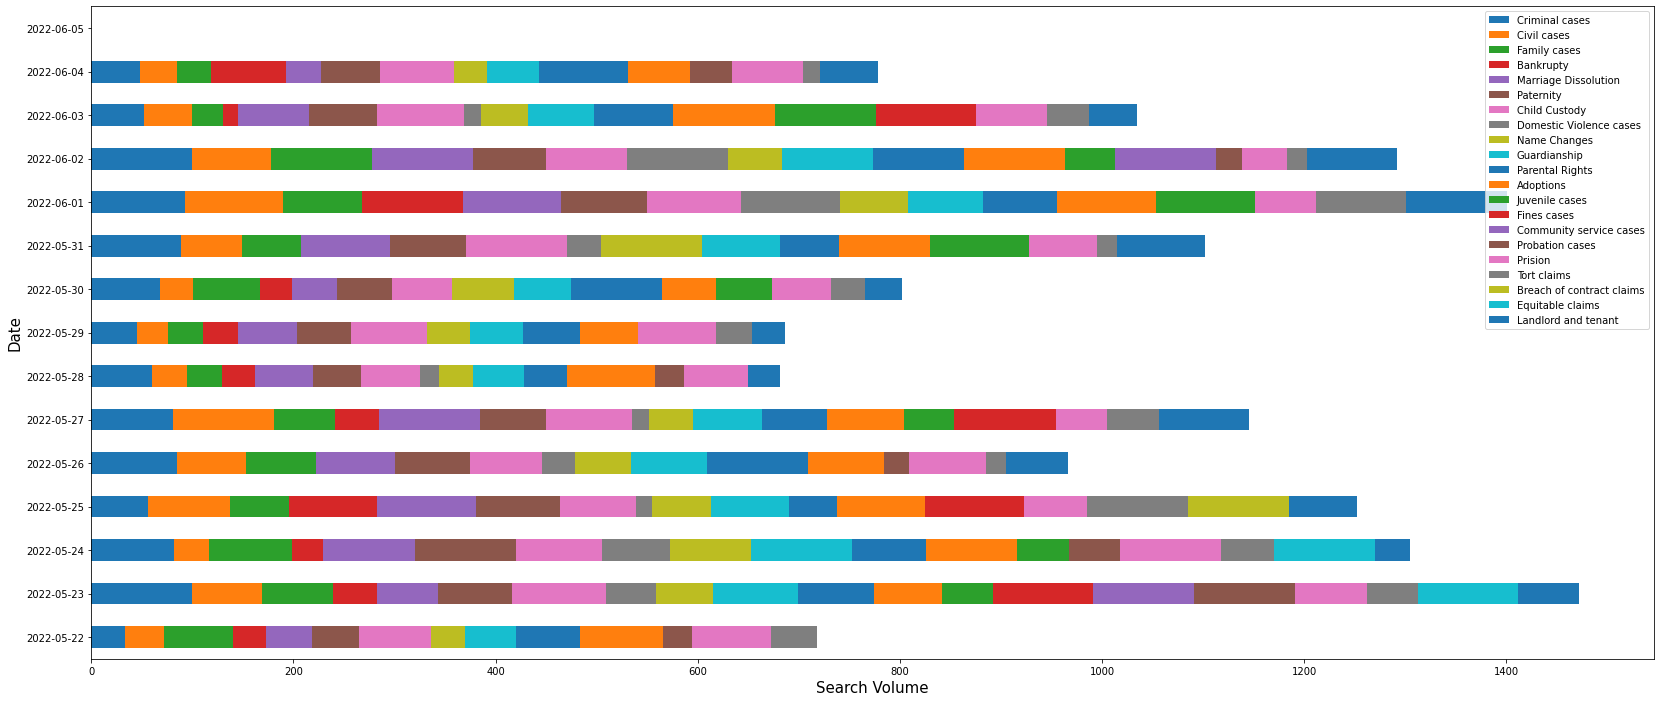

In [ ]:
# 3. Get Search Volumns by using Search Google Trend
# Function
def google_trends(search, date_range):
    pytrends = TrendReq(hl="en-US", tz=360)
    kw_list = [search]
    try :
        pytrends.build_payload(kw_list, timeframe=date_range[0], geo='US')
        # Retrieve the interest Over time
        trends = pytrends.interest_over_time()
        #related_queries = pytrends.related_queries()
        
    except Exception as e:
        print("\nGoogle Search Trend retrieval failed.")
        print(e)
        return
    return trends


# last 2 weeks Google Trend
now = datetime.datetime.now()
two_week = now - relativedelta(days=16)
date_range = ["%s %s" % (two_week.strftime('%Y-%m-%d'), now.strftime('%Y-%m-%d'))]

# Search Dataframe
google_watch_hist = pd.DataFrame()
#search_query = [m + " case" for m in genre]
search_query = genre

for s in search_query:
    trend = google_trends(s, date_range)
    google_watch_hist[s] = trend[s].tolist()

google_watch_hist['date'] = trend.index.tolist()
google_watch_hist.set_index(pd.PeriodIndex(google_watch_hist.date, freq="D"), inplace=True)
google_watch_hist.drop('date', axis=1, inplace=True)

# Plot
google_watch_hist.plot(kind='barh', stacked=True, figsize=(28, 12))
plt.xlabel("Search Volume",  fontsize=15)
plt.ylabel("Date",  fontsize=15)
plt.legend()


# 4. Weight Formula
search_score = dict()

for g in genre:
    search_score[g] = stats.zscore(google_watch_hist[g])[-1]
x = np.asarray([val for key, val in search_score.items()])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

genre_weights = softmax(x)

# Weight Formula : w_i : genre_weight, x_i : encoded genre text
search_encoded_vector = np.asarray(sum([item * weight for item, weight in zip(items, genre_weights)]))
search_encoded_vector = search_encoded_vector.reshape((1, 768))

In [ ]:
# 1. Get semantic outputs
print("******* Original Semantic Law Cases Search *******")
semantic_outputs, _ = law_bert.search(user_query = my_query, top_k = 10, index = index_1)
candidate_plots = [x['judgment_summary'] for x in semantic_outputs]
embeddings = law_bert.model.encode(candidate_plots)

# 2. Compute Cosine-sim for each sentence with search_vector
cosine_scores = util.pytorch_cos_sim(search_encoded_vector, embeddings)
for (i, score) in zip(semantic_outputs, cosine_scores.numpy()[0]):
    i['search_score'] = score

# 3. Sorting by search_score
online_outputs = sorted(semantic_outputs, key=lambda x: x['search_score'], reverse = True)

print("\n\n\n\n ******* Online-based Filtering ******* \n\n")
for i, out in enumerate(online_outputs):
   print("\n === Law Cases ===")
   print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

******* Original Semantic Law Cases Search *******

 === Calculate run time : 75.0263 ms === 

>> Write your case : 세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다.

 >> Top 1 - Case name (Number) : 상속세등부과처분취소 (92누10197)  
 | Cluster : 1 
 | Cluster's Topics (Keywords) : [('소유권이전등기를', 0.012397482982072997), ('매도인이', 0.010670625950776547), ('매수인이', 0.009588375067566041), ('부동산을', 0.008512627687063684), ('제3자에게', 0.007602555570412245), ('민법', 0.00731358808583595), ('양수인이', 0.007173534321099034), ('소유권을', 0.006959985911133866), ('매도인의', 0.0066327192736526305), ('부동산의', 0.0065590039511267), ('매수인', 0.006361639696070237), ('양도인의', 0.006217732794087703), ('매수인의', 0.006158225999130342), ('채무를', 0.006136810123188872), ('경우', 0.006095651826107116), ('양도', 0.00594887873501919), ('사정이', 0.00562086912164356), ('부동산에', 0.005614533770911688), ('양도인이', 0.005589818313526113), ('특별한', 0.0055663420948754185)] 
 | Date : 19921009.0 | Judgment Issue : 피상속인의 대지 매각대금이 제3자에게 입금교부된 사실이 밝혀졌을지라도 제3자에 대한 채무의 존재사실이 확인되지 않은 경우 상속세

## 4-4. Dynamic Poist-filtering result

In [ ]:
print("\n")
print("\n >> Write your case :", my_query)
print("\n")

# Case name (Case number) : Judgment issue (cluster_name) 
results = pd.DataFrame()
results['Only Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in original_outputs]
results['Popularity-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in p_outputs]
results['User-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in user_outputs]
results['Online-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in online_outputs]
results




 >> Write your case : 세입자가 3개월째 집주인인 저에게 월세를 주지 않습니다.




,Only Semantic Search,Popularity-based Semantic Search,User-based Semantic Search,Online-based Semantic Search
0,상속세등부과처분취소 (92누10197) : 피상속인의 대지 매각대금이 제3자에게 입...,소유권이전등기 (81다257) : 가 양도담보권자가 담보물에 제3자를 위한 가등기를...,과징금부과처분취소 (2005두3257) : 1 부동산 실권리자명의 등기에 관한 법률...,가옥명도청구사건 (78나862) : 건물 신축공사 수급인의 공사잔대금 채권과 유치권 항변
1,물적납세의무자지정등처분취소 (87누827) : 가 국세기본법 제42조 제1항 단서 ...,종합소득세부과처분취소 (80누288) : 원천소득세가 원천징수되었으나 세무관서에 납...,가처분이의 (80다2632) : 제3자 명의의 가등기가 경료된 부동산에 관하여 처분...,물적납세의무자지정등처분취소 (87누827) : 가 국세기본법 제42조 제1항 단서 ...
2,소유권이전등기말소청구사건 (73나419) : 가등기담보권자가 그 담보권실행을 위한 ...,계미청구사건 (75나1523) : 계금을 탈 차례의 계원이 그 계날에 계금을 타지못...,집행문부여청구사건 (86가단2845) : 화해당사자의 집행문부여의 소의 당사자적격,상속세등부과처분취소 (92누10197) : 피상속인의 대지 매각대금이 제3자에게 입...
3,소유권이전등기 (94다32610) : 채무자가 제3채무자에 대하여 가지는 택지수분양...,상속세등부과처분취소 (92누10197) : 피상속인의 대지 매각대금이 제3자에게 입...,추심금 (96다10867) : 가압류 압류 및 추심명령의 대상인 임차보증금 잔금채권...,제소명령 (93마1435) : 소유권이전등기청구권에 대한 처분금지가처분의 제3채무자...
4,제소명령 (93마1435) : 소유권이전등기청구권에 대한 처분금지가처분의 제3채무자...,물적납세의무자지정등처분취소 (87누827) : 가 국세기본법 제42조 제1항 단서 ...,체비지변상금조정부과처분취소 (94누4318) : 점용할 정당한 권한 없는 제3자로부...,소유권이전등기 (89다카21125) : 가등기담보부동산의 매매예약 당시의 시가가 피...
5,소유권이전등기 (89다카21125) : 가등기담보부동산의 매매예약 당시의 시가가 피...,소유권이전등기말소청구사건 (73나419) : 가등기담보권자가 그 담보권실행을 위한 ...,종합소득세부과처분취소 (80누288) : 원천소득세가 원천징수되었으나 세무관서에 납...,소유권이전등기 (94다32610) : 채무자가 제3채무자에 대하여 가지는 택지수분양...
6,가옥명도청구사건 (78나862) : 건물 신축공사 수급인의 공사잔대금 채권과 유치권 항변,가옥명도청구사건 (78나862) : 건물 신축공사 수급인의 공사잔대금 채권과 유치권 항변,부가가치세부과처분취소 (89누2844) : 사안이 단순하여 용이하게 조사할 수 있는...,소유권이전등기말소청구사건 (73나419) : 가등기담보권자가 그 담보권실행을 위한 ...
7,종합소득세부과처분취소 (80누288) : 원천소득세가 원천징수되었으나 세무관서에 납...,소유권이전등기 (89다카21125) : 가등기담보부동산의 매매예약 당시의 시가가 피...,과불금반환 (68다605) : 지방자치단체인 충청남도 소유 부동산의 매각으로 인한 ...,종합소득세부과처분취소 (80누288) : 원천소득세가 원천징수되었으나 세무관서에 납...
8,소유권이전등기 (81다257) : 가 양도담보권자가 담보물에 제3자를 위한 가등기를...,제소명령 (93마1435) : 소유권이전등기청구권에 대한 처분금지가처분의 제3채무자...,양도소득세등부과처분취소 (88구10789) : 소득세법시행령 제115조 제3항 및 ...,계미청구사건 (75나1523) : 계금을 탈 차례의 계원이 그 계날에 계금을 타지못...
9,계미청구사건 (75나1523) : 계금을 탈 차례의 계원이 그 계날에 계금을 타지못...,소유권이전등기 (94다32610) : 채무자가 제3채무자에 대하여 가지는 택지수분양...,채무부존재확인등 (80다1468) : 근저당권설정계약상의 채무자 아닌 자를 채무자로...,소유권이전등기 (81다257) : 가 양도담보권자가 담보물에 제3자를 위한 가등기를...
